In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import random
import random
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/snacks.csv')

In [4]:
def is_in_range(chromosome,min_snacks,max_snacks):
    num_snacks = 0
    for index,weight in chromosome:
      if(weight != 0):
        num_snacks += 1

    if (num_snacks >= min_snacks and num_snacks <= max_snacks):
      return True
    else:
      return False

def sum_weights(chromosome):
    total_weight = 0
    for gene in chromosome:
        index, weight = gene
        total_weight += weight
    return total_weight

def set_weights_to_zero(chromosome, min_threshold, max_threshold, min_snacks, max_snacks):

    listof_modified_chromosomes = []
    step = (max_threshold - min_threshold) / 100
    for threshold in np.arange(min_threshold, max_threshold, step):
      modified_chromosome = []
      for index, weight in chromosome:
          modified_weight = 0.0 if weight < threshold else weight
          modified_chromosome.append((index, modified_weight))
      listof_modified_chromosomes.append(modified_chromosome)
    in_range_chromosomes = []
    for chromos in listof_modified_chromosomes:
      if(is_in_range(chromos, min_snacks, max_snacks) == True):
        in_range_chromosomes.append(chromos)
    list_of_weights = []

    for in_range_chromos in in_range_chromosomes:
      list_of_weights.append(sum_weights(in_range_chromos))
    best_index = list_of_weights.index(min(list_of_weights))
    best_chromosome = in_range_chromosomes[best_index]
    return best_chromosome



In [5]:
def apply_mutation(offspring, pm, min_weight_mutation, max_weight_mutation):
    mutated_offspring = []
    for parent in offspring:
        mutated_parent = []
        for gene in parent:
            index, weight = gene

            # Apply mutation to the weight with probability pm
            if random.random() < pm:
                mutation_direction = random.choice([-1, 1])
                # Generate a random mutation for the weight
                weight_mutation = random.uniform(min_weight_mutation, max_weight_mutation)
                mutated_weight = weight + mutation_direction * weight_mutation  # Mutate the weight
            else:
                mutated_weight = weight  # Keep the weight unchanged

            # Append the mutated gene to the mutated parent
            mutated_parent.append((index, mutated_weight))
        mutated_offspring.append(tuple(mutated_parent))  # Convert list to tuple
    return mutated_offspring

In [6]:
def three_point_crossover(parent1, parent2):
    # Choose three random crossover points
    crossover_points = sorted(random.sample(range(1, len(parent1) - 1), 3))

    # Perform crossover
    child1 = parent1[:crossover_points[0]] + parent2[crossover_points[0]:crossover_points[1]] + parent1[crossover_points[1]:crossover_points[2]] + parent2[crossover_points[2]:]
    child2 = parent2[:crossover_points[0]] + parent1[crossover_points[0]:crossover_points[1]] + parent2[crossover_points[1]:crossover_points[2]] + parent1[crossover_points[2]:]

    return child1, child2

def apply_crossover_with_probability(mating_pool, pc):
    offspring = []
    for i in range(0, len(mating_pool), 2):
        if i + 1 < len(mating_pool):
            parent1 = mating_pool[i]
            parent2 = mating_pool[i + 1]

            # Check if crossover should be applied based on probability pc
            if random.random() < pc:
                child1, child2 = three_point_crossover(parent1, parent2)
            else:
                child1 = parent1[:]
                child2 = parent2[:]

            offspring.extend([child1, child2])
        else:
            # If there's an odd number of parents, just copy the last parent
            offspring.append(mating_pool[-1][:])
    return offspring

In [7]:
def calculate_fitness(genome, df, min_num_snacks, max_num_snacks, min_value, max_weight):
    fitness = 0
    total_value = 0
    total_weight = 0
    total_Available_weight = 0
    total_Available_value = 0
    num_snacks = 0
    for index, weight in genome:
        if (weight != 0):
            num_snacks += 1
            total_Available_value += df.loc[index, 'Value']
            value = df.loc[index, 'Value']
            total_value += value * weight / df.loc[index, 'Available Weight']
            total_weight += weight
            total_Available_weight += df.loc[index, 'Available Weight']

    fitness =  20000 * total_value
    #print(total_weight)
    #print(max_weight)
    #print(total_Available_weight)
    #print(total_value)
    #constraints
    penalty = 0
    if total_weight > max_weight:
        penalty -=  900000 * (total_weight - max_weight)
        fitness = 0
    # if total_weight > total_Available_weight:
    #     fitness = fitness - 20/100 * total_Available_value
    if total_value < min_value:
        penalty -= 300000 * (min_value - total_value)
        fitness = 0
    if num_snacks < min_num_snacks:
        penalty -= 300000 * (min_num_snacks - num_snacks)
        fitness = 0
    if num_snacks > max_num_snacks:
        penalty -= 300000 * (num_snacks - max_num_snacks)
        fitness = 0
    for index, weight in genome:
            snack_Available_weight = df.loc[index, 'Available Weight']
            if weight > snack_Available_weight:
                penalty -= 100000 * (weight - snack_Available_weight)
                fitness = 0
            elif weight < 0:
                fitness = 0
                penalty -= 3000000 * (0 - weight)

    final_value = fitness + penalty
    return final_value

In [8]:
def generate_population(df, population_size, min_snacks, max_snacks):
    # Read the CSV file


    # Generate population
    population = []
    for _ in range(population_size):
        num_snacks = random.randint(min_snacks, max_snacks)  # Randomly choose the number of snacks
        genome = []
        selected_indexes = set()  # Keep track of selected indexes
        while len(genome) < num_snacks:
            snack_index = random.randint(0, len(df) - 1)  # Randomly select a snack from the list
            if snack_index not in selected_indexes:  # Check if the index is not already selected
                selected_indexes.add(snack_index)  # Add the index to the set of selected indexes
                max_snack_weight = df.loc[snack_index, 'Available Weight']  # Get the maximum weight allowed for the selected snack
                snack_weight = random.uniform(0, max_snack_weight)  # Generate a random weight for the snack
                genome.append((snack_index, snack_weight))  # Store the index and weight of the chosen snack

        # Initialize a new chromosome with weights set to zero
        new_chromosome = [(i, 0) for i in range(19)]

        # Update weights in the new chromosome based on the generated genome
        for index, weight in genome:
            new_chromosome[index] = (index, weight)

        population.append(new_chromosome)

    return population

In [9]:
def calculate_population_fitness(population, df, min_snacks, max_snacks, min_value, max_weight):
    fitness_scores = []
    for genome in population:
        fitness = calculate_fitness(genome, df, min_snacks, max_snacks, min_value, max_weight)
        fitness_scores.append(fitness)
    return fitness_scores

In [10]:
def roulette_wheel_selection(population, fitness_scores, num_parents):
    total_fitness = sum(fitness_scores)
    selection_probabilities = [fitness / total_fitness for fitness in fitness_scores]

    cumulative_probabilities = [0]
    for prob in selection_probabilities:
        cumulative_probabilities.append(cumulative_probabilities[-1] + prob)

    selected_parents = []
    for _ in range(num_parents):
        random_value = random.random()
        for i in range(len(cumulative_probabilities) - 1):
            if cumulative_probabilities[i] <= random_value <= cumulative_probabilities[i+1]:
                selected_parents.append(population[i])
                break

    return selected_parents

In [11]:
def k_tournament_selection(population, fitness_scores, k):
    selected_parents = []
    for _ in range(len(population)):
        # Randomly select k individuals from the population
        tournament_pool = random.sample(range(len(population)), k)

        # Find the index of the individual with the highest fitness score in the tournament pool
        winner_index = max(tournament_pool, key=lambda x: fitness_scores[x])

        # Add the corresponding chromosome to the selected parents
        selected_parents.append(population[winner_index])

    return selected_parents

In [ ]:
# Example usage:
max_generations = 200
initial_parents = 1000
Pc = 0.2
Pm = 0.2
min_mutation = 0
max_mutation = 0.5
# Example usage:
  # Replace 'snacks.csv' with the path to your CSV file
population_size = 1000
k = 800
min_value = float(input("Enter the minimum value of snacks a person can carry: "))
max_weight = float(input("Enter the maximum weight of snacks a person can carry: "))
min_snacks = int(input("Enter the minimum number of snacks a person can carry: "))
max_snacks = int(input("Enter the maximum number of snacks a person can carry: "))
#set initial random population
population = generate_population(df, population_size, min_snacks, max_snacks)
#print(population)
mean_fitness_scores = []
for i in range(max_generations):


    # if i == 20 or i == 40 or i == 80 or i == 100:
    #     print("Generation:", i)
    #     max_fitness_index = fitness_scores.index(max(fitness_scores))
    #     print(population[max_fitness_index])
    #     print(fitness_scores)
    if i == 50 or i == 100 or i == 150 or i == 199:
        print("Generation:", i)
        max_fitness_index = fitness_scores.index(max(fitness_scores))
        print(population[max_fitness_index])
        print(fitness_scores)

    #print("Generation:", i)
    offspring = []
    fitness_scores = calculate_population_fitness(population, df, min_snacks, max_snacks, min_value, max_weight)
    #print(fitness_scores)
    #mating_pool = roulette_wheel_selection(population, fitness_scores, initial_parents)
    #mating_pool = top_one_hundred(population, fitness_scores)
    mating_pool = k_tournament_selection(population, fitness_scores, k)
    random.shuffle(mating_pool)
    offspring = apply_crossover_with_probability(mating_pool, Pc)
    mutated_offspring = apply_mutation(offspring, Pm, min_mutation, max_mutation)
    population = mutated_offspring
    mean_fitness_scores.append(np.mean(fitness_scores))


Enter the minimum value of snacks a person can carry: 7
Enter the maximum weight of snacks a person can carry: 6
Enter the minimum number of snacks a person can carry: 2
Enter the maximum number of snacks a person can carry: 4


In [25]:

min_threshold = 0.01
max_threshold = 0.2

max_fitness_index = fitness_scores.index(max(fitness_scores))
print("sum of weights in best answer : ", int(sum_weights(population[max_fitness_index])))
best_answer = population[max_fitness_index]
print("best answer : ",best_answer)
total_value1 = 0
num_items1 = 0
for index, weight in best_answer:
        if (weight != 0):
            num_items1 += 1
            value = df.loc[index, 'Value']
            total_value1 += value * weight / df.loc[index, 'Available Weight']
print("sum of values in best answer : ", int(total_value1))
print("number of snacks : ", num_items1)

tuned_best_answer = set_weights_to_zero(population[max_fitness_index], min_threshold, max_threshold, min_snacks, max_snacks)
print("tuned best answer : ",tuned_best_answer)
total_value2 = 0
num_items2 = 0

for index, weight in tuned_best_answer:
        if (weight != 0):

            num_items2 += 1
            value = df.loc[index, 'Value']
            total_value2 += value * weight / df.loc[index, 'Available Weight']
print("sum of weights in best answer : ", int(sum_weights(tuned_best_answer)))
print("sum of values in best answer : ", int(total_value2))
print("number of snacks tuned : ", num_items2)

sum of weights in best answer :  4
best answer :  ((0, 0), (1, 0), (2, 0.0593305250821653), (3, -0.06608205545660861), (4, 0), (5, 0.03521572706950127), (6, 0.0006283484879443524), (7, 0), (8, 0), (9, 0.3254668805917311), (10, 0.09329587463013445), (11, 0.03751937477480022), (12, 0.39614190491765444), (13, 0.3955432633719855), (14, 0), (15, 3.4475987272257704), (16, 0), (17, -0.08245782804554908), (18, 0))
sum of values in best answer :  5
number of snacks :  11
tuned best answer :  [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.3254668805917311), (10, 0.09329587463013445), (11, 0.0), (12, 0.39614190491765444), (13, 0.3955432633719855), (14, 0.0), (15, 3.4475987272257704), (16, 0.0), (17, 0.0), (18, 0.0)]
sum of weights in best answer :  4
sum of values in best answer :  5
number of snacks tuned :  5


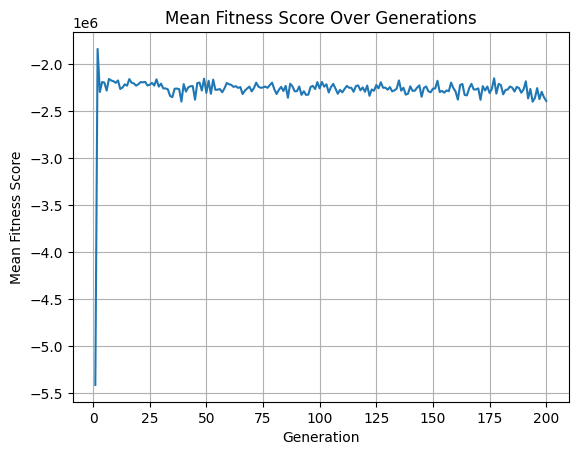

In [14]:
import matplotlib.pyplot as plt
# Plot mean fitness scores over generations
plt.plot(range(1, max_generations + 1), mean_fitness_scores)
plt.xlabel('Generation')
plt.ylabel('Mean Fitness Score')
plt.title('Mean Fitness Score Over Generations')
plt.grid(True)
plt.show()

In [26]:
# Show genes with non-zero weights
list_of_snacks = []
for gene_index, weight in tuned_best_answer:
    if weight != 0:
        snack_name = df.iloc[gene_index]['Snack']
        list_of_snacks.append((snack_name,weight))
        print(f"Snack: {snack_name}, Weight: {weight}")

Snack: Cookies, Weight: 0.3254668805917311
Snack: Abnabat, Weight: 0.09329587463013445
Snack: Popcorn, Weight: 0.39614190491765444
Snack: Pastil, Weight: 0.3955432633719855
Snack: Masghati, Weight: 3.4475987272257704


In [27]:

# Construct the HTML table dynamically
html_table = "<table border='1'><tr><th>Snack</th><th>Weight</th></tr>"
for snack, weight in list_of_snacks:
    html_table += f"<tr><td>{snack}</td><td>{weight}</td></tr>"
html_table += "</table>"

# Write HTML content to file
with open('/content/drive/MyDrive/output.html', 'w') as file:
    file.write(html_table)